# Project 2 - Sport Classification

### Maximilian Dermek, Marian Kurcina
<br>

## Table of Contents
- Data Analysis
- Data preprocessing and normalization
- Data Split
- Augmentations
- Configuration
- Experiment tracking
- Experiments
- Results and evaluation metrics
- Code
- Conclusion

<br>

In [1]:
import kagglehub
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

## Data Analysis

First we download the dateset contents from kagglehub.

In [2]:
path = kagglehub.dataset_download("gpiosenka/sports-classification")
print(os.listdir(path))

100%|███████████████████████████████████████████████████████████████████████████████| 424M/424M [00:35<00:00, 12.4MB/s]

Extracting files...


['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'test', 'train', 'valid']


We can see there is dataset split into the three parts, test, train and valid dataset. 

In [3]:
csv_path = os.path.join(path, "sports.csv")
df = pd.read_csv(csv_path)
print(df.head())
print(df.info())

   class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB
None


In the dataset files we have also a csv file containg classes, filepaths, labels of images and to which data set they belong to.

In [4]:
print("Classes:", df['class id'].unique())
print("Number of classes:", df['class id'].nunique())

counts = df['class id'].value_counts()
print(counts)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Number of classes: 100
class id
31    201
32    200
58    199
7     184
41    182
     ... 
44    112
3     109
99    108
91    107
77     69
Name: count, Length: 100, dtype: int64


We have 100 classes with various number of images for each.

In [5]:
train_count = df['filepaths'].str.startswith('train/').sum()
valid_count = df['filepaths'].str.startswith('valid/').sum()
test_count  = df['filepaths'].str.startswith('test/').sum()

print(f"Train images: {train_count}")
print(f"Valid images: {valid_count}")
print(f"Test images: {test_count}")

Train images: 13493
Valid images: 500
Test images: 500


The number of test and valid images is too small, therefore we will add to them some images from train dataset.


In [6]:
import shutil

updated_rows = []

def move_files(rows, new_split):
        for _, row in rows.iterrows():
            old_path = row["filepaths"] 
            img_name = os.path.basename(old_path)
            img_name = f"{new_split}_{img_name}"
            new_path = os.path.join(new_split, row["labels"], img_name)

            old_abs = os.path.normpath(os.path.join(path, old_path))
            new_abs = os.path.normpath(os.path.join(path, new_path))

            os.makedirs(os.path.dirname(new_abs), exist_ok=True)
            shutil.move(old_abs, new_abs)

            new_row = row.copy()
            new_row["filepaths"] = new_path
            new_row["data set"] = new_split
            updated_rows.append(new_row)

for label in df["class id"].unique():
    class_rows = df[(df["class id"] == label) & (df["data set"] == "train")]
    
    test_samples = class_rows.sample(5)
    remaining = class_rows.drop(test_samples.index)
    val_samples = remaining.sample(5)
    remaining = class_rows.drop(val_samples.index)
    
    move_files(test_samples, "test")
    move_files(val_samples, "valid")

    remaining_train = df[(df["class id"] == label) & (df["data set"] == "train") \
                         & (~df.index.isin(test_samples.index)) \
                         & (~df.index.isin(val_samples.index))]

    for _, row in remaining_train.iterrows():
        updated_rows.append(row)


other_splits = df[df["data set"] != "train"]
updated_rows.extend([r for _, r in other_splits.iterrows()])
df = pd.DataFrame(updated_rows)
new_path = os.path.join(path, "new_sports.csv")
df.to_csv(new_path, index=False)

print(df.head())
print(df.info())

train_count = df['filepaths'].str.startswith('train').sum()
valid_count = df['filepaths'].str.startswith('valid').sum()
test_count  = df['filepaths'].str.startswith('test').sum()

print(f"Train images: {train_count}")
print(f"Valid images: {valid_count}")
print(f"Test images: {test_count}")

     class id                     filepaths      labels data set
92          0  test\air hockey\test_093.jpg  air hockey     test
76          0  test\air hockey\test_077.jpg  air hockey     test
42          0  test\air hockey\test_043.jpg  air hockey     test
108         0  test\air hockey\test_109.jpg  air hockey     test
25          0  test\air hockey\test_026.jpg  air hockey     test
<class 'pandas.core.frame.DataFrame'>
Index: 14493 entries, 92 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 566.1+ KB
None
Train images: 12493
Valid images: 1000
Test images: 1000


In [7]:
train_counts = df[df['filepaths'].str.startswith('train')]['class id'].value_counts()
print("Train counts per class:")
print(train_counts)

valid_counts = df[df['filepaths'].str.startswith('valid')]['class id'].value_counts()
print("\nValidation counts per class:")
print(valid_counts)

test_counts = df[df['filepaths'].str.startswith('test')]['class id'].value_counts()
print("\nTest counts per class:")
print(test_counts)

Train counts per class:
class id
31    181
32    180
58    179
7     164
41    162
     ... 
44     92
3      89
99     88
91     87
77     49
Name: count, Length: 100, dtype: int64

Validation counts per class:
class id
0     10
1     10
2     10
3     10
4     10
      ..
95    10
96    10
97    10
98    10
99    10
Name: count, Length: 100, dtype: int64

Test counts per class:
class id
0     10
1     10
2     10
3     10
4     10
      ..
95    10
96    10
97    10
98    10
99    10
Name: count, Length: 100, dtype: int64


([], [])

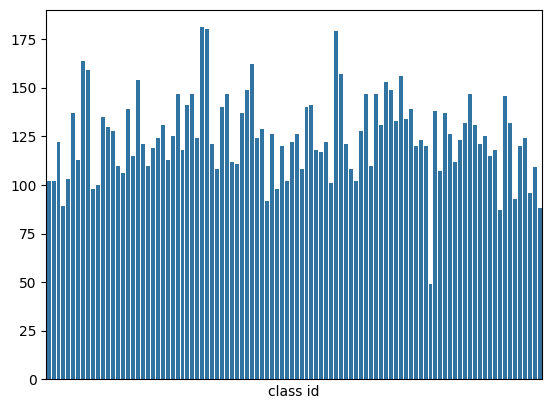

In [8]:
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.xticks([])

([], [])

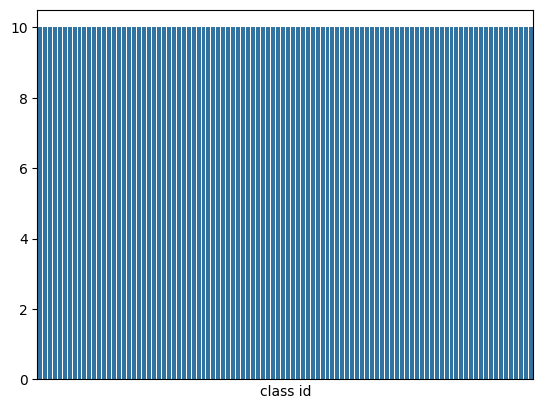

In [9]:
sns.barplot(x=valid_counts.index, y=valid_counts.values)
plt.xticks([])

([], [])

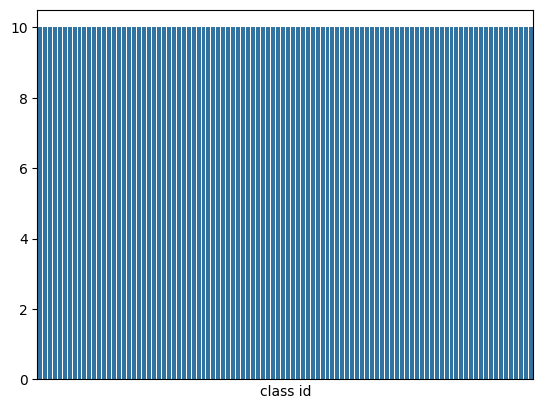

In [10]:
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.xticks([])

We can now see that each class for validation and test has 10 images.

Next we will test if we can open all images. Those we cannot open we will drop. We will also test if all images have same sizes.

In [11]:
sizes = []
rows_to_drop = []


valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

for idx,img_path in df['filepaths'].items():
    full_path = os.path.normpath(os.path.join(path, img_path))
    

    if not os.path.exists(full_path):
        rows_to_drop.append(idx)
        continue
    

    if not full_path.lower().endswith(valid_extensions):
        rows_to_drop.append(idx)
        continue

    img = Image.open(full_path)
    sizes.append(img.size)

if sizes:
    widths, heights = zip(*sizes)
    print("Width: min =", min(widths), "max =", max(widths))
    print("Height: min =", min(heights), "max =", max(heights))
else:
    print("No valid images found!")

df_clean = df.drop(index=rows_to_drop).reset_index(drop=True)

print(f"Dropped {len(rows_to_drop)} invalid images")
print(f"Remaining images: {len(df_clean)}")


Width: min = 224 max = 224
Height: min = 224 max = 224
Dropped 1 invalid images
Remaining images: 14492


## Data preprocessing and normalization

In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

NUM_CLASSES = df_clean['class id'].nunique()

In [13]:
def preprocess_image(img_path, label, augment=False):
    full_path = tf.strings.join([path, img_path], separator=os.sep)
    img = tf.io.read_file(full_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([224, 224, 3])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        pass
    
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

## Augmentations

In [14]:
def preprocess_image(img_path, label, augment=False):
    full_path = tf.strings.join([path, img_path], separator=os.sep)
    img = tf.io.read_file(full_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([224, 224, 3])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_hue(img, 0.05)
    
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

## Data Split

In [15]:
def create_dataset(df_split, augment=False):
    paths = df_split['filepaths'].values
    labels = df_split['class id'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: preprocess_image(x, y, augment), 
                num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_df = df_clean[df_clean['filepaths'].str.startswith('train')]
valid_df = df_clean[df_clean['filepaths'].str.startswith('valid')]
test_df  = df_clean[df_clean['filepaths'].str.startswith('test')]

train_ds_without_aug = create_dataset(train_df, augment=False)
train_ds = create_dataset(train_df, augment=True)
valid_ds = create_dataset(valid_df)
test_ds  = create_dataset(test_df)

## Final Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06337282..1.1705301].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11809203..0.8714433].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06166525..0.8222061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1461494..0.79469085].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21935157..1.1660018].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09895319..0.854133].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.102

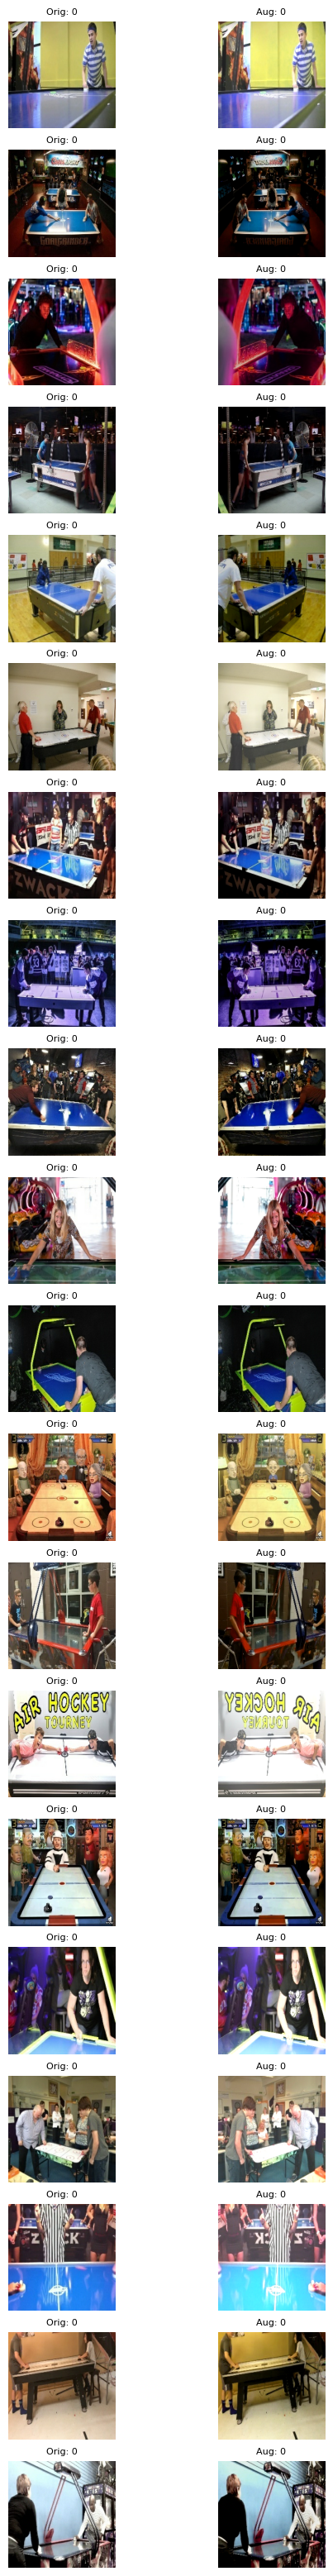

In [16]:
orig_batch = next(iter(train_ds_without_aug))
aug_batch  = next(iter(train_ds))

orig_images, orig_labels = orig_batch
aug_images, aug_labels   = aug_batch

plt.figure(figsize=(6, 40)) 
num_images = min(20, orig_images.shape[0]) 

for i in range(num_images):
    # Original
    ax = plt.subplot(20, 2, 2*i + 1)
    plt.imshow(orig_images[i].numpy())
    plt.axis("off")
    plt.title(f"Orig: {tf.argmax(orig_labels[i]).numpy()}", fontsize=8)

    # Augmented
    ax = plt.subplot(20, 2, 2*i + 2)
    plt.imshow(aug_images[i].numpy())
    plt.axis("off")
    plt.title(f"Aug: {tf.argmax(aug_labels[i]).numpy()}", fontsize=8)

plt.show()



In [17]:
print("\n\n___IMAGE 0 (numeric values)___\n")
print(orig_images[0].numpy())



___IMAGE 0 (numeric values)___

[[[0.44313726 0.28627452 0.1882353 ]
  [0.21960784 0.07450981 0.        ]
  [0.1882353  0.0627451  0.01960784]
  ...
  [0.10196079 0.10980392 0.05490196]
  [0.08627451 0.09019608 0.06666667]
  [0.08627451 0.09411765 0.07450981]]

 [[0.48235294 0.31764707 0.21960784]
  [0.21960784 0.07058824 0.        ]
  [0.21176471 0.08627451 0.04313726]
  ...
  [0.10196079 0.10196079 0.05490196]
  [0.10196079 0.10588235 0.07450981]
  [0.08627451 0.09411765 0.07450981]]

 [[0.49803922 0.32156864 0.2       ]
  [0.3764706  0.21176471 0.11764706]
  [0.24313726 0.10196079 0.04705882]
  ...
  [0.10588235 0.10588235 0.05882353]
  [0.09803922 0.10196079 0.07058824]
  [0.08235294 0.09411765 0.06666667]]

 ...

 [[0.16470589 0.19215687 0.37254903]
  [0.16862746 0.19607843 0.36862746]
  [0.18039216 0.20784314 0.37254903]
  ...
  [0.2509804  0.27058825 0.15294118]
  [0.27058825 0.29411766 0.15294118]
  [0.2627451  0.28627452 0.13725491]]

 [[0.14901961 0.1764706  0.34901962]
  [

## Configuration

## Experiment tracking

## Experiments

## Results and evaluation metrics

## Code 

## Conclusion